In [90]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
#import torchvision.models as models
import torchvision.transforms as transforms
from collections import defaultdict
history_dict = defaultdict(list)

In [91]:
# CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_data = CIFAR10(root='data', train=True, download=False, transform=None)
train_size = int(len(train_data) * 0.8)
valid_size = len(train_data) - train_size
train_data, valid_data = data.random_split(train_data, (train_size, valid_size))
test_data = CIFAR10(root='data', train=False, download=False, transform=None)
print('Dataset size: train={}, validation={}, test={}'.format(len(train_data), len(valid_data), len(test_data)))

Dataset size: train=40000, validation=10000, test=10000


In [92]:
def preview(dataset):
    offset = 0
    fig, axs = plt.subplots(1, 10, figsize=(20,20))
    for i, ax in enumerate(axs):
        img = dataset[i+offset][0]
        target = dataset[i+offset][1]
        ax.imshow(img)
        if classes != None:
            label = classes[dataset[i+offset][1]]
            ax.set_title('{}: {}'.format(target, label))
        else:
            ax.set_title(target)
        ax.set_xticks([])
        ax.set_yticks([])
        offset = offset + 100
    plt.show()

TRAIN


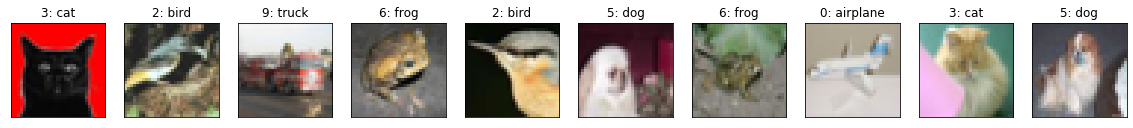

VALIDATION


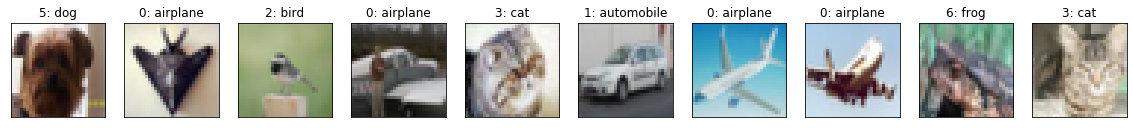

TEST


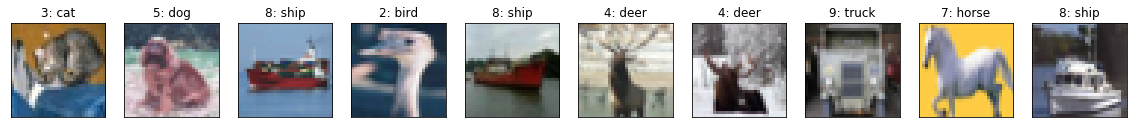

In [93]:
print('TRAIN')
preview(train_data)
print('VALIDATION')
preview(valid_data)
print('TEST')
preview(test_data)

In [137]:
batch_size = 200

train_transf = transforms.Compose([
    #transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])
test_transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_data = CIFAR10(root='data', train=True, download=False, transform=train_transf)
train_size = int(len(train_data) * 0.8)
valid_size = len(train_data) - train_size
train_data, valid_data = data.random_split(train_data, (train_size, valid_size))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = CIFAR10(root='data', train=False, download=False, transform=test_transf)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [138]:
def train_epoch(model, device, train_loader, optimizer, criterion, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        history_dict['loss'].append(loss.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('  {:5}/{} ({:2.0f}%)\tLoss: {:.6f}'.
                  format(batch_idx * len(data),
                         len(train_loader.dataset),
                         100. * batch_idx / len(train_loader),
                         loss.item()))


def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    
    return accuracy

def train(model, optimizer, scheduler, criterion, train_loader, test_loader, device, lr, nb_epochs=3, log_interval=100):
    for epoch in range(1, nb_epochs + 1):
        print('================================================================================')
        print('\nEpoch {}/{} - Training at LR {:.6}\n'.format(epoch, nb_epochs, scheduler.get_lr()[0]))
        
        train_epoch(model, device, train_loader, optimizer, criterion, log_interval)
        
        acc = test(model, device, criterion, valid_loader)
        
        print('\n  Validation accuracy: {:.2f}%\n'.format(acc))
        
        history_dict['val_acc'].append(acc)
        
        scheduler.step()
    
    return acc

def plot_curves(loss_values, val_acc):
    fig, ax = plt.subplots(2, 1, figsize=(15,5))
    ax[0].set_title('Training Loss')
    ax[0].plot(loss_values)
    ax[0].set_title('Loss')
    ax[0].set_xticks([])
    ax[1].set_title('Validation Accuracy')
    ax[1].plot(val_acc)
    ax[1].set_xticks([])

In [139]:
class ScratchNet(nn.Module):
    def __init__(self):
        super(ScratchNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(p=drop_pct, inplace=True),
            nn.BatchNorm2d(32)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(p=drop_pct, inplace=True),
            nn.BatchNorm2d(64)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(p=drop_pct, inplace=True),
            nn.BatchNorm2d(128)
        )
        self.fc1 = nn.Linear(4*4*128, 512)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.bn = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [144]:
device = torch.device('cuda:0') #'cpu'
print('Batch size:', batch_size)
nb_epochs = 40
log_interval = 20
lr = 1e-2
step_size=10
drop_pct = 0.2

Batch size: 200


In [145]:
model = ScratchNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device)


Epoch 1/40 - Training at LR 0.01

      0/40000 ( 0%)	Loss: 3.286710
   4000/40000 (10%)	Loss: 6.887043
   8000/40000 (20%)	Loss: 2.272979
  12000/40000 (30%)	Loss: 1.633112
  16000/40000 (40%)	Loss: 1.671830
  20000/40000 (50%)	Loss: 1.592560
  24000/40000 (60%)	Loss: 1.559738
  28000/40000 (70%)	Loss: 1.532080
  32000/40000 (80%)	Loss: 1.631134
  36000/40000 (90%)	Loss: 1.476273

  Validation accuracy: 47.46%


Epoch 2/40 - Training at LR 0.01

      0/40000 ( 0%)	Loss: 1.310720
   4000/40000 (10%)	Loss: 1.485358
   8000/40000 (20%)	Loss: 1.449845
  12000/40000 (30%)	Loss: 1.361891
  16000/40000 (40%)	Loss: 1.432483
  20000/40000 (50%)	Loss: 1.430019
  24000/40000 (60%)	Loss: 1.299034
  28000/40000 (70%)	Loss: 1.393444
  32000/40000 (80%)	Loss: 1.355005
  36000/40000 (90%)	Loss: 1.328803

  Validation accuracy: 54.36%


Epoch 3/40 - Training at LR 0.01

      0/40000 ( 0%)	Loss: 1.305922
   4000/40000 (10%)	Loss: 1.396827
   8000/40000 (20%)	Loss: 1.525192
  12000/40000 (30%)	Loss: 

  12000/40000 (30%)	Loss: 0.558657
  16000/40000 (40%)	Loss: 0.595568
  20000/40000 (50%)	Loss: 0.574273
  24000/40000 (60%)	Loss: 0.560066
  28000/40000 (70%)	Loss: 0.366496
  32000/40000 (80%)	Loss: 0.514274
  36000/40000 (90%)	Loss: 0.575625

  Validation accuracy: 79.01%


Epoch 18/40 - Training at LR 0.001

      0/40000 ( 0%)	Loss: 0.559360
   4000/40000 (10%)	Loss: 0.477586
   8000/40000 (20%)	Loss: 0.488490
  12000/40000 (30%)	Loss: 0.638226
  16000/40000 (40%)	Loss: 0.469895
  20000/40000 (50%)	Loss: 0.556213
  24000/40000 (60%)	Loss: 0.549952
  28000/40000 (70%)	Loss: 0.595227
  32000/40000 (80%)	Loss: 0.601797
  36000/40000 (90%)	Loss: 0.538543

  Validation accuracy: 79.68%


Epoch 19/40 - Training at LR 0.001

      0/40000 ( 0%)	Loss: 0.581911
   4000/40000 (10%)	Loss: 0.483867
   8000/40000 (20%)	Loss: 0.472582
  12000/40000 (30%)	Loss: 0.468864
  16000/40000 (40%)	Loss: 0.508067
  20000/40000 (50%)	Loss: 0.503345
  24000/40000 (60%)	Loss: 0.521124
  28000/40000 (70%)	Lo

  36000/40000 (90%)	Loss: 0.483097

  Validation accuracy: 80.00%


Epoch 34/40 - Training at LR 1e-05

      0/40000 ( 0%)	Loss: 0.268712
   4000/40000 (10%)	Loss: 0.541604
   8000/40000 (20%)	Loss: 0.400724
  12000/40000 (30%)	Loss: 0.303063
  16000/40000 (40%)	Loss: 0.447542
  20000/40000 (50%)	Loss: 0.311239
  24000/40000 (60%)	Loss: 0.497743
  28000/40000 (70%)	Loss: 0.403484
  32000/40000 (80%)	Loss: 0.409648
  36000/40000 (90%)	Loss: 0.344030

  Validation accuracy: 80.00%


Epoch 35/40 - Training at LR 1e-05

      0/40000 ( 0%)	Loss: 0.410603
   4000/40000 (10%)	Loss: 0.436469
   8000/40000 (20%)	Loss: 0.361748
  12000/40000 (30%)	Loss: 0.352110
  16000/40000 (40%)	Loss: 0.433977
  20000/40000 (50%)	Loss: 0.382216
  24000/40000 (60%)	Loss: 0.430414
  28000/40000 (70%)	Loss: 0.453329
  32000/40000 (80%)	Loss: 0.500942
  36000/40000 (90%)	Loss: 0.494026

  Validation accuracy: 80.10%


Epoch 36/40 - Training at LR 1e-05

      0/40000 ( 0%)	Loss: 0.514845
   4000/40000 (10%)	Los

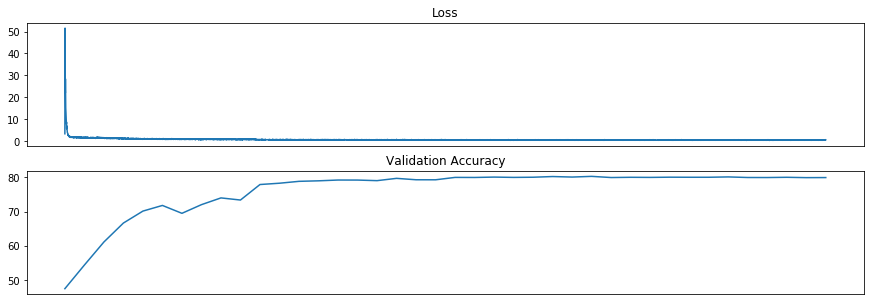

In [146]:
history_dict = defaultdict(list)
acc = train(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))
plot_curves(history_dict['loss'], history_dict['val_acc'])

In [147]:
acc = test(model, device, criterion, test_loader)
        
print('\n  Validation accuracy: {:.2f}%\n'.format(acc))


  Validation accuracy: 79.68%

